In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.datasets import CIFAR10
import torch.nn.functional as F
import numpy as np

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این قسمت ابتدا دیتاست Cifar10 دانلود شده مورد استفاده قرار می گیرد.
دیتالودر موردنظر روی دو کلاس موردنظر ساخته و ترنسفورم روی آن اعمال می شود.
<br>

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Select a subset of classes
selected_classes = [0, 1]
train_filtered_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] in selected_classes]
test_filtered_indices = [i for i in range(len(test_dataset)) if test_dataset.targets[i] in selected_classes]

subset_train_dataset = torch.utils.data.Subset(train_dataset, train_filtered_indices)
subset_test_dataset = torch.utils.data.Subset(test_dataset, test_filtered_indices)


100%|██████████| 170498071/170498071 [00:02<00:00, 69395699.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
این کلاس "TripletDataset" برای ساخت یک مجموعه داده از سه‌تایی‌ها (Triplet) بر اساس یک مجموعه دادهٔ پایه ایجاد شده است. هر سه‌تایی شامل سه نمونه از مجموعه داده است:

1. "Anchor": یک نمونه انتخاب شده به عنوان نقطهٔ مرجع.
2. "Positive": یک نمونه انتخاب شده از همان دستهٔ برچسبی که "Anchor" از آن انتخاب شده است.
3. "Negative": یک نمونه انتخاب شده از یک دستهٔ برچسبی متفاوت از "Anchor".

در واقعیت، این کلاس تصادفی یک نمونه "Anchor" را انتخاب کرده و سپس یک نمونه "Positive" از همان دستهٔ برچسبی که "Anchor" انتخاب شده است و یک نمونه "Negative" از یک دستهٔ برچسبی متفاوت انتخاب می‌کند. این عملیات به تناوب برای تمام نمونه‌های موجود در مجموعه داده اجرا می‌شود.
پ
<br>

In [ ]:
class TripletDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.labels = np.array(self.base_dataset.dataset.targets)
        self.label_to_indices = {label: np.where(self.labels == label)[0] for label in self.labels}

    def __getitem__(self, index):
        target = np.random.choice(self.labels)
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[target])
        negative_target = np.random.choice(list(set(self.labels) - {target}))
        negative_index = np.random.choice(self.label_to_indices[negative_target])
        anchor = self.base_dataset.dataset[index][0]
        positive = self.base_dataset.dataset[positive_index][0]
        negative = self.base_dataset.dataset[negative_index][0]
        return anchor, positive, negative

    def __len__(self):
        return len(self.base_dataset)

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
اد کردن دیتالودر کلی و دیتا لودر triplet
<br>

In [ ]:
triplet_train_dataset = TripletDataset(subset_train_dataset)
triplet_test_dataset = TripletDataset(subset_test_dataset)

triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=64, shuffle=True)
triplet_test_loader = DataLoader(triplet_test_dataset, batch_size=64, shuffle=False)


classifier_train_dataset = torch.utils.data.Subset(train_dataset, train_filtered_indices)
classifier_test_dataset = torch.utils.data.Subset(test_dataset, test_filtered_indices)

classifier_train_loader = DataLoader(classifier_train_dataset, batch_size=128, shuffle=True)
classifier_test_loader = DataLoader(classifier_test_dataset, batch_size=128, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print(device)

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
مدل alexnet
<br>

In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 133MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
شخصی سازی کردن مدل alexnet و تعریف توابع loss برای triplet , classifier
<br>

In [ ]:
num_classes_cifar = 2
alexnet.classifier[-1] = nn.Linear(4096, num_classes_cifar)

# Define the triplet loss criterion
triplet_criterion = nn.TripletMarginLoss(margin=0.2)

# Define the classification loss criterion
classifier_criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(alexnet.parameters(), lr=0.001)

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این قسمت کلاسی جهت پیاده سازی لاس ترکیبی نوشته می شود.
بدین صورت که لاس کلی جمع لاس triplet و لاس classifier است.
<br>

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, triplet_criterion, classifier_criterion):
        super(CombinedLoss, self).__init__()
        self.triplet_criterion = triplet_criterion
        self.classifier_criterion = classifier_criterion

    def forward(self, anchor_output, positive_output, negative_output, classifier_output, labels):
        # Calculate triplet loss
        triplet_loss = self.triplet_criterion(anchor_output, positive_output, negative_output)

        # Calculate classification loss
        classifier_loss = self.classifier_criterion(classifier_output, labels)

        # Combine both losses
        total_loss = triplet_loss + classifier_loss

        return total_loss


In [ ]:
combined_criterion = CombinedLoss(triplet_criterion, classifier_criterion)


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این قسمت تابعی جهت ترین کردن نوشته می شود. به گونه ای که به ازای positive , negative , anchor تولید شده نتیجه حاصل می شود. سپس تابع loss روی تمام دیتا بسته می شود.

در نهایت تست نیز به همین ترتیب انجام می شود.

<br>

In [ ]:
def train_combined_model(model, combined_criterion, optimizer, triplet_train_loader, classifier_train_loader, triplet_test_loader, classifier_test_loader, device, num_epochs=10):
    model.train()
    total_loss_list = []
    accuracy_list = []
    loss_list = []
    val_accuracy_list = []
    train_accuracy_list = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_loss = 0.0
        correct_train = 0
        total_train = 0

        for (anchor, positive, negative), (images, labels) in zip(triplet_train_loader, classifier_train_loader):
            anchor, positive, negative, images, labels = anchor.to(device), positive.to(device), negative.to(device), images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass for triplet loss
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            # Forward pass for classification
            classifier_output = model(images)

            # Calculate combined loss
            loss = combined_criterion(anchor_output, positive_output, negative_output, classifier_output, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(classifier_output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_loss = total_loss / len(classifier_train_loader)
        train_accuracy = correct_train / total_train
        train_accuracy_list.append(train_accuracy)
        # Validation
        model.eval()
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in classifier_test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val

        val_accuracy_list.append(val_accuracy)
        loss_list.append(average_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {average_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')
    accuracy_list.append(train_accuracy)
    accuracy_list.append(val_accuracy)
    print('Training finished.')

    return total_loss_list, accuracy_list



<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این قسمت تابع ترین ترکیبی فراخوانی شده شده و نتایج بدست می آید.
<br>

In [ ]:
# Assume you have already defined your model, criterion, optimizer, and data loaders

total_loss_list, accuracy_list = train_combined_model(
    alexnet,
    combined_criterion,
    optimizer,
    triplet_train_loader,
    classifier_train_loader,
    triplet_test_loader,
    classifier_test_loader,
    device,
    num_epochs=100
)



Epoch [1/100], Training Loss: 3.0771, Training Accuracy: 0.6135, Validation Accuracy: 0.8110
Epoch [2/100], Training Loss: 1.1283, Training Accuracy: 0.7968, Validation Accuracy: 0.8025
Epoch [3/100], Training Loss: 0.9698, Training Accuracy: 0.8218, Validation Accuracy: 0.8545
Epoch [4/100], Training Loss: 0.9240, Training Accuracy: 0.8273, Validation Accuracy: 0.8340
Epoch [5/100], Training Loss: 0.8674, Training Accuracy: 0.8495, Validation Accuracy: 0.8355
Epoch [6/100], Training Loss: 0.8465, Training Accuracy: 0.8561, Validation Accuracy: 0.5880
Epoch [7/100], Training Loss: 0.8275, Training Accuracy: 0.8453, Validation Accuracy: 0.5510
Epoch [8/100], Training Loss: 0.7812, Training Accuracy: 0.8777, Validation Accuracy: 0.9025
Epoch [9/100], Training Loss: 0.7727, Training Accuracy: 0.8707, Validation Accuracy: 0.8995
Epoch [10/100], Training Loss: 0.7388, Training Accuracy: 0.8891, Validation Accuracy: 0.6420
Epoch [11/100], Training Loss: 0.7401, Training Accuracy: 0.8743, Val

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در نهایت به ازای نتایج بدست آمده نمودار های مربوطه رسم می شود.

نکته : validation acc همان نتیجه دقت تست است.
توجه شود نوسان موجود در دقت تست ، می تواند با تنظیم learning rate برطرف شود.
<br>

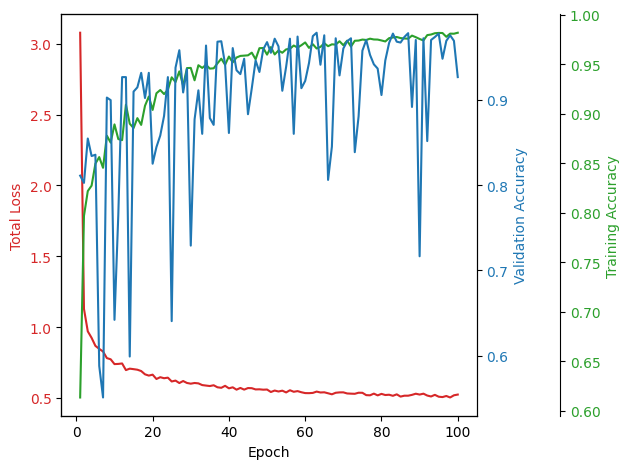

In [ ]:
# Plot the training loss and validation accuracy over epochs
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss', color=color)
ax1.plot(range(1, 101), total_loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Add training accuracy to the plot
ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 60))
ax2.set_ylabel('Training Accuracy', color=color)
ax2.plot(range(1, 101), accuracy_list[0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:blue'
ax3.set_ylabel('Validation Accuracy', color=color)
ax3.plot(range(1, 101), accuracy_list[1], color=color)
ax3.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()
